In [30]:
import pandas as pd

df = pd.read_csv("../healthcare_dataset.csv")

df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])

daily_admissions = df.groupby("Date of Admission").size()

daily_admissions = daily_admissions.rename("admissions")
daily_admissions = daily_admissions.sort_index()
daily_admissions = daily_admissions.asfreq("D", fill_value=0)

print(daily_admissions.head())
print(daily_admissions.tail())
print(daily_admissions.index.freq)

Date of Admission
2019-05-08    27
2019-05-09    38
2019-05-10    17
2019-05-11    25
2019-05-12    36
Freq: D, Name: admissions, dtype: int64
Date of Admission
2024-05-03    31
2024-05-04    24
2024-05-05    26
2024-05-06    33
2024-05-07    33
Freq: D, Name: admissions, dtype: int64
<Day>


In [31]:
import numpy as np

def make_lag_features(series, n_lags=7):
    df_ml = pd.DataFrame({"admissions": series})
    
    #For Lag 1,2,...n
    for lag in range(1, n_lags + 1):
        df_ml[f"lag_{lag}"] = series.shift(lag)
    
    # Calendar features
    df_ml["day_of_week"] = df_ml.index.dayofweek  # 0=Mon ... 6=Sun
    df_ml["month"] = df_ml.index.month
    
    # Droprows that became NaN becuase of shifting
    df_ml = df_ml.dropna()
    return df_ml

ml_df = make_lag_features(daily_admissions, n_lags=7)

print(ml_df.head())
print(ml_df.tail())

                   admissions  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
Date of Admission                                                         
2019-05-15                 39   33.0   23.0   36.0   25.0   17.0   38.0   
2019-05-16                 27   39.0   33.0   23.0   36.0   25.0   17.0   
2019-05-17                 35   27.0   39.0   33.0   23.0   36.0   25.0   
2019-05-18                 18   35.0   27.0   39.0   33.0   23.0   36.0   
2019-05-19                 33   18.0   35.0   27.0   39.0   33.0   23.0   

                   lag_7  day_of_week  month  
Date of Admission                             
2019-05-15          27.0            2      5  
2019-05-16          38.0            3      5  
2019-05-17          17.0            4      5  
2019-05-18          25.0            5      5  
2019-05-19          36.0            6      5  
                   admissions  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
Date of Admission                                                     

In [32]:
data_ml = ml_df.sort_index()

train_size = int(len(data_ml) * 0.7)

train_ml = data_ml.iloc[:train_size]
test_ml  = data_ml.iloc[train_size:]

# Features (X) and Target (y)
feature_cols = ['lag_1', 'lag_7', 'day_of_week', 'month']

X_train = train_ml[feature_cols]
y_train = train_ml['admissions']

X_test  = test_ml[feature_cols]
y_test  = test_ml['admissions']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train period:", X_train.index.min(), "to", X_train.index.max())
print("Test period :", X_test.index.min(), "to", X_test.index.max())

Train shape: (1274, 4) Test shape: (546, 4)
Train period: 2019-05-15 00:00:00 to 2022-11-08 00:00:00
Test period : 2022-11-09 00:00:00 to 2024-05-07 00:00:00


In [33]:
# 70/30 split

data_ml = ml_df.dropna().sort_index()

train_size = int(len(data_ml) * 0.7)

train_ml = data_ml.iloc[:train_size]
test_ml  = data_ml.iloc[train_size:]

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return rmse, mae, mape, accuracy

In [35]:
#Random Forest Model 1

from sklearn.ensemble import RandomForestRegressor

rf_model_1 = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train_fit_model
rf_model_1.fit(X_train, y_train)
y_pred_rf_1 = rf_model_1.predict(X_test)
rmse1, mae1, mape1, acc1 = evaluate_model(y_test, y_pred_rf_1)

print("Random Forest model-1 trained.")

Random Forest model-1 trained.


In [36]:
#Random Forest Model 2

rf_model_2 = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model_2.fit(X_train, y_train)
y_pred_rf_2 = rf_model_2.predict(X_test)
rmse2, mae2, mape2, acc2 = evaluate_model(y_test, y_pred_rf_2)

print("Random Forest model-2 trained.")

Random Forest model-2 trained.


In [37]:
#Random Forest Model 3

rf_model_3 = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model_3.fit(X_train, y_train)
y_pred_rf_3 = rf_model_3.predict(X_test)
rmse3, mae3, mape3, acc3 = evaluate_model(y_test, y_pred_rf_3)

print("Random Forest model-3 trained.")

Random Forest model-3 trained.


In [38]:
#Random Forest Model 4

rf_model_4 = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model_4.fit(X_train, y_train)
y_pred_rf_4 = rf_model_4.predict(X_test)
rmse4, mae4, mape4, acc4 = evaluate_model(y_test, y_pred_rf_4)

print("Random Forest model-4 trained.")

Random Forest model-4 trained.


In [39]:
#Random Forest Model 5

rf_model_5 = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_model_5.fit(X_train, y_train)
y_pred_rf_5 = rf_model_5.predict(X_test)
rmse5, mae5, mape5, acc5 = evaluate_model(y_test, y_pred_rf_5)

print("Random Forest model-5 trained.")

Random Forest model-5 trained.


In [40]:
rf_pred_df = pd.DataFrame({
    "date": y_test.index,
    "rf_1": y_pred_rf_1,
    "rf_2": y_pred_rf_2,
    "rf_3": y_pred_rf_3,
    "rf_4": y_pred_rf_4,
    "rf_5": y_pred_rf_5
})

In [41]:
rf_results = pd.DataFrame({
    "Model": ["RF-1", "RF-2", "RF-3", "RF-4", "RF-5"],
    "RMSE": [rmse1, rmse2, rmse3, rmse4, rmse5],
    "MAE":  [mae1,  mae2,  mae3,  mae4,  mae5],
    "MAPE (%)": [mape1, mape2, mape3, mape4, mape5],
    "Accuracy": [acc1, acc2, acc3, acc4, acc5]
})

rf_results

,Model,RMSE,MAE,MAPE (%),Accuracy
0,RF-1,6.571369,5.256068,18.642810,81.357190
1,RF-2,6.307557,5.072458,18.034368,81.965632
2,RF-3,6.578658,5.275439,18.721148,81.278852
3,RF-4,6.321012,5.066672,17.983014,82.016986
4,RF-5,6.413172,5.147030,18.270701,81.729299


In [42]:
rf1_series = pd.Series(y_pred_rf_1, index=y_test.index)
rf2_series = pd.Series(y_pred_rf_2, index=y_test.index)
rf3_series = pd.Series(y_pred_rf_3, index=y_test.index)
rf4_series = pd.Series(y_pred_rf_4, index=y_test.index)
rf5_series = pd.Series(y_pred_rf_5, index=y_test.index)

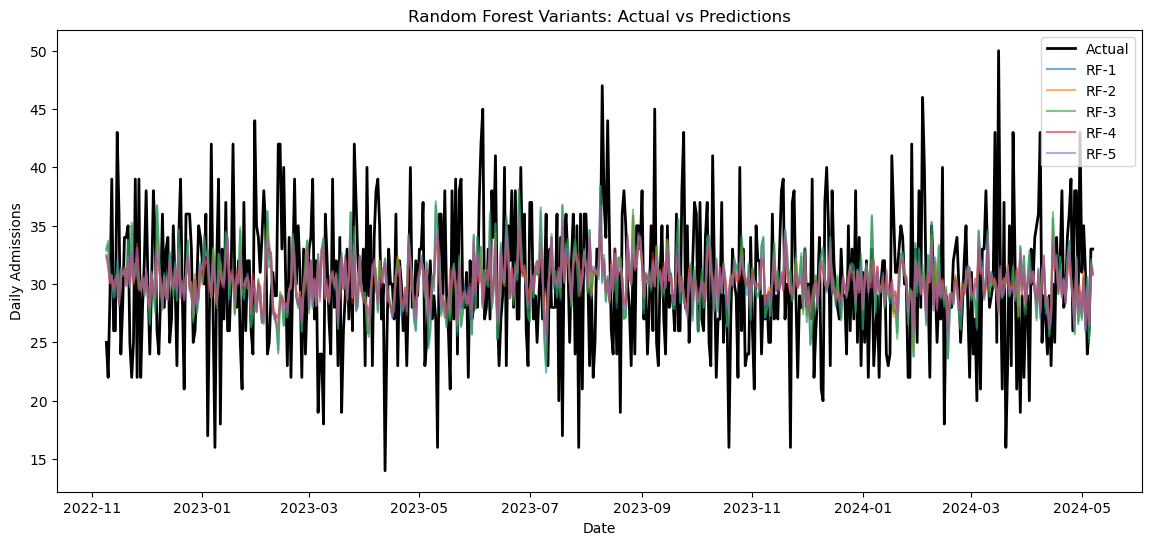

In [43]:
#Plotting

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(y_test.index, y_test, label="Actual", color="black", linewidth=2)

plt.plot(rf1_series, label="RF-1", alpha=0.6)
plt.plot(rf2_series, label="RF-2", alpha=0.6)
plt.plot(rf3_series, label="RF-3", alpha=0.6)
plt.plot(rf4_series, label="RF-4", alpha=0.6)
plt.plot(rf5_series, label="RF-5", alpha=0.6)

plt.title("Random Forest Variants: Actual vs Predictions")
plt.xlabel("Date")
plt.ylabel("Daily Admissions")
plt.legend()
plt.show()

In [44]:
rf_pred_df.to_csv("../70_30 split/predictions/rf_predictions.csv", index=False)
print("Random Forest predictions saved to rf_predictions.csv")

Random Forest predictions saved to rf_predictions.csv
